In [1]:
import s3fs
import pyarrow.parquet as pq
import pyarrow as pa
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import duckdb
import os

from datetime import datetime

In [2]:
plt.style.use('ggplot')
conn = duckdb.connect()

In [3]:
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/K8s/minio/minio-certs/cert-authority.pem",
    }
)

In [20]:
firms = pq.read_table("dutrajardim-fi/tables/firms/osm_adm8.parquet", filesystem=fs)

shapes_relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=8", filesystem=fs)
shapes = pq.read_table("dutrajardim-fi/tables/shapes/osm/shapes.parquet/adm=8", filesystem=fs)

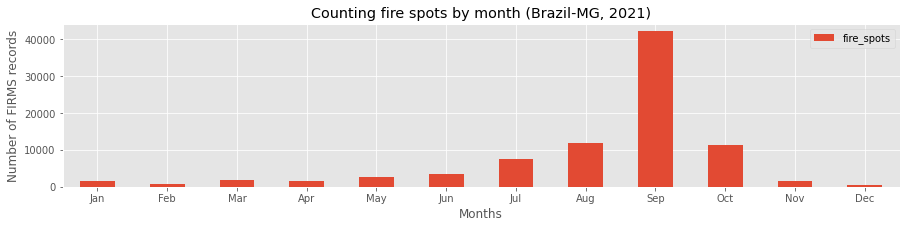

In [15]:
for year in range(2019, 2022):
    fire_counts_by_month = conn.execute(f"""
    SELECT COUNT(*) AS fire_spots, STRFTIME(FIRST(datetime), '%b') as month_name, month
    FROM firms
    WHERE 
        adm4_name = 'Minas Gerais' AND 
        YEAR(datetime) = {year}
    GROUP BY month
    ORDER BY month ASC
    """).df()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))

    fire_counts_by_month.plot(
        kind="bar",
        title=f"Counting fire spots by month (Brazil-MG, {year})",
        xlabel="Months",
        ylabel="Number of FIRMS records",
        x="month_name",
        y="fire_spots",
        ax=ax,
        rot=0
    )

    fig.savefig(f"../docs/images/charts/BRA_MG/counting_fire_spots_by_month/{year}.svg") 
    
    if year != 2021:
        plt.close(fig)

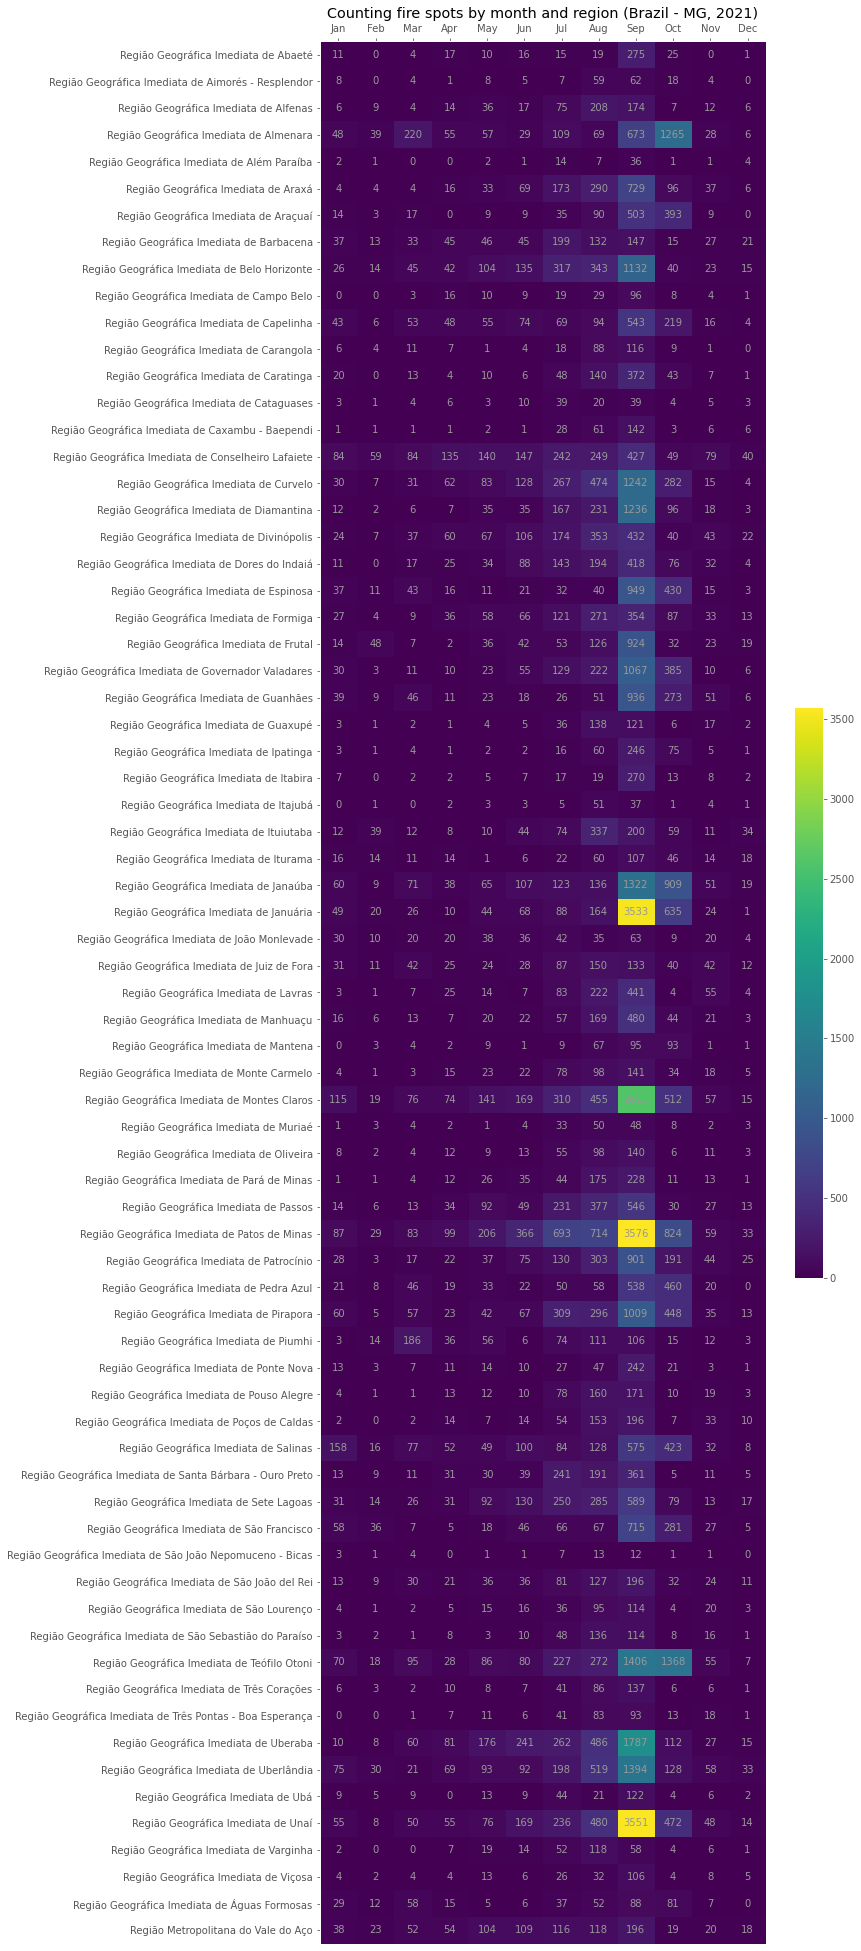

In [16]:
plt.rcParams['axes.grid'] = False

for year in range(2019, 2022):
    counting_by_region_and_month = conn.execute(f"""
    SELECT 
        CASE WHEN adm7_name IS NOT NULL THEN adm7_name ELSE adm6_name END AS region, 
        COUNT(*) AS fire_spots, 
        STRFTIME(FIRST(datetime), '%b') as month_name, 
        month
    FROM firms
    WHERE 
        adm4_name = 'Minas Gerais' AND 
        YEAR(datetime) = {year}
    GROUP BY adm7_name, adm6_name, month
    ORDER BY month_name
    """).df()

    pivot = ( 
        counting_by_region_and_month
        .pivot_table(index='region', columns=['month_name', 'month'], values='fire_spots', fill_value=0)
        .sort_index(axis=1, level='month')
    )

    fig, ax = plt.subplots(figsize=(10,35))

    im = ax.imshow(pivot.values, aspect='auto', interpolation='nearest')

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(pivot.columns)), labels=pivot.columns.get_level_values('month_name'))
    ax.set_yticks(np.arange(len(pivot.index)), labels=pivot.index)

    # Loop over data dimensions and create text annotations.
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            text = ax.text(j, i, pivot.values[i, j], ha="center", va="center", color="#999")


    ax.set_title(f"Counting fire spots by month and region (Brazil - MG, {year})")

    fig.colorbar(im, shrink=.3)
    # plt.tight_layout()
    fig.savefig(f"../docs/images/charts/BRA_MG/counting_fire_spots_by_month_and_region/{year}.svg") 
    
    if year != 2021:
        plt.close(fig)

plt.rcParams['axes.grid'] = True

In [ ]:
shapes_mg = conn.execute("""
SELECT shapes.id, shapes.geometry
FROM shapes
JOIN shapes_relations ON shapes_relations.id = shapes.id
WHERE adm4_name = 'Minas Gerais'
""").df()

firms_mg = conn.execute("""
SELECT firms.geometry, shapes_relations.id, firms.month, datetime
FROM firms
JOIN shapes_relations ON (firms.adm8 = shapes_relations.id)
WHERE adm4_name = 'Minas Gerais' AND YEAR(datetime) = 2021
""").df()

fire_counts_by_city_and_month = conn.execute("""
SELECT COUNT(*) AS fire_spots, id, month
FROM firms
WHERE adm4_name = 'Minas Gerais' AND YEAR(datetime) = 2021
GROUP BY id, month
""").df()

In [19]:
firms.column_names

['geometry',
 'bright_ti4',
 'bright_ti5',
 'frp',
 'scan',
 'track',
 'confidence',
 'type',
 'instrument',
 'datetime',
 'adm2',
 'adm2_name',
 'adm3',
 'adm3_name',
 'adm4',
 'adm4_name',
 'adm5',
 'adm5_name',
 'adm6',
 'adm6_name',
 'adm7',
 'adm7_name',
 'year',
 'month']

In [18]:
year = 2021

for month in range(1, 13):
    monthly_fire_counts = conn.execute(f"""
    SELECT CASE WHEN fire_spots IS NOT NULL THEN fire_spots ELSE 0 END AS fire_spots, geometry
    FROM 
        (SELECT COUNT(*) AS fire_spots, adm
        FROM firms
        WHERE 
            adm4_name = 'Minas Gerais' AND 
            MONTH(datetime) = {month} AND
            YEAR(datetime) = {year}
        GROUP BY adm, month)
        
        counting
    
    RIGHT JOIN
        (SELECT shapes.id, shapes.geometry
        FROM shapes
        JOIN shapes_relations ON shapes_relations.id = shapes.id
        WHERE adm4_name = 'Minas Gerais')
        
        shapes_mg
    
    ON counting.adm = shapes_mg.id
    """).df()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax.set_title(f"Counting fire spots by month and city (Brazil - MG, {year}-{month})")

    gdf_monthly_fire_counts = gp.GeoDataFrame(
        monthly_fire_counts, 
        geometry=gp.GeoSeries.from_wkt(monthly_fire_counts['geometry'])
    )
    gdf_monthly_fire_counts.plot(column='fire_spots', legend=True, ax=ax, shrink=.8)

    fig.savefig(f"../docs/images/maps/BRA_MG/counting_fire_spots_by_city/year_{year}/month_{month}.svg") 
    
    if month != 12:
        plt.close(fig)

RuntimeError: Binder Error: Referenced column "adm" not found in FROM clause!
Candidate bindings: "firms.adm7", "firms.adm6", "firms.adm5", "firms.adm4", "firms.adm2"

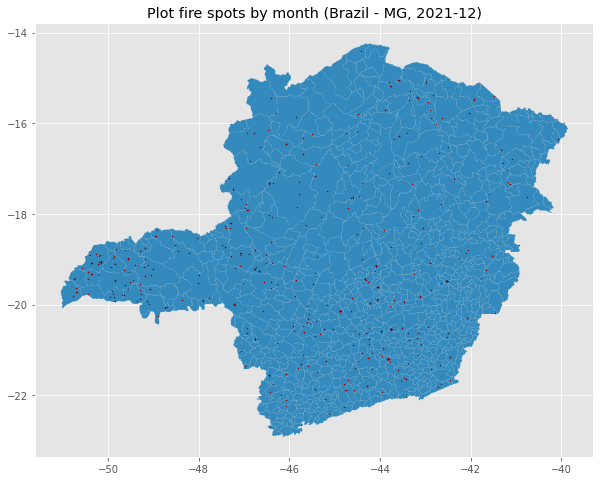

In [188]:
for month in range(1, 13):
    monthly_firms_mg = conn.execute(f"SELECT geometry FROM firms_mg WHERE month = {month}").df()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax.set_title(f"Plot fire spots by month (Brazil - MG, 2021-{month})")

    gdf_shapes_mg = gp.GeoDataFrame(
        shapes_mg.copy(), 
        geometry=gp.GeoSeries.from_wkt(shapes_mg['geometry'])
    )
    gdf_shapes_mg.plot(ax=ax)

    gdf_monthly_firms_mg = gp.GeoDataFrame(
        monthly_firms_mg, 
        geometry=gp.GeoSeries.from_wkt(monthly_firms_mg['geometry'])
    )
    gdf_monthly_firms_mg.plot(ax=ax, color='darkred', markersize=.8)

    fig.savefig(f"../docs/images/maps/BRA_MG/fire_spots/month_2021-{month}.svg") 
    
    if month != 12:
        plt.close(fig)